In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import tkinter.filedialog as tkf
import hyperspy.api as hys
from scipy import optimize
from ipywidgets import interact
import ipywidgets as widgets
import time

In [2]:
hys.preferences.gui()

In [2]:
# refer to https://scipy-cookbook.readthedocs.io/items/FittingData.html

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape) # row, col
    x = (X*data).sum()/total # row
    y = (Y*data).sum()/total # col
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum()) # row
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum()) # col
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [3]:
# refer to "github.com/mkolopanis/python/blob/master/radialProfile.py"

def radial_average_with_center(image, profile_resolution=1.0, center=None):
   
    y, x = np.indices(image.shape) * profile_resolution
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0]*profile_resolution, x - center[1]*profile_resolution)
    #plt.imshow(r, cmap="Accent")
    #plt.show()

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = np.around(r_sorted)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    #print(nr)
    
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [4]:
def gaussian_center(image, cbox_edge=0):
    y, x = np.indices(image.shape)
    if not cbox_edge:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    else:
        cbox_outy = int(image.shape[0]/2 - cbox_edge/2)
        cbox_outx = int(image.shape[1]/2 - cbox_edge/2)
        center_box = image[cbox_outy:-cbox_outy, cbox_outx:-cbox_outx]
        fit_params = fitgaussian(center_box)
        (_, center_y, center_x, _, _) = fit_params
        center = [center_y+cbox_outy, center_x+cbox_outx]
        
    return center

In [5]:
def remove_center_beam(image, center=None, cb_rad=0):
    y, x = np.indices(image.shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0], x - center[1])
    r = np.around(r)
    ri = np.where(r<=cb_rad)
    #print(ri[0].shape)
    
    image[ri] = 0
    
    return image

In [6]:
# refer to github.com/mkolopanis/python/blob/master/radialProfile.py

def radial_variance(image, profile_resolution=1.0, center=None):
   
    y, x = np.indices(image.shape) * profile_resolution
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0]*profile_resolution, x - center[1]*profile_resolution)
    #plt.imshow(r, cmap="Accent")
    #plt.show()

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = np.around(r_sorted)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    csim = np.cumsum(i_sorted, dtype=float)
    sq_csim = np.cumsum(np.square(i_sorted), dtype=float)
    
    #plt.plot(np.square(csim), c="red")
    #plt.plot(sq_csim, c="blue")
    
    avg_square = np.square((csim[rind[1:]] - csim[rind[:-1]]) / nr)
    square_avg = (sq_csim[rind[1:]] - sq_csim[rind[:-1]]) / nr
    
    #plt.plot(avg_square[20:], c="red")
    #plt.plot(square_avg[20:], c="blue")
    
    radial_var = square_avg - avg_square
    
    return radial_var    

In [7]:
def radial_variance_with_angle(image, angle_range=None, center=None):
    
    y, x = np.indices(image.shape)
    
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
    
    angle_arr = np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            angle_arr[i, j] = np.angle(complex(x[i, j]-center[1], y[i, j]-center[0]), deg=True)
            
    angle_arr = angle_arr + 180
    angle_arr = np.around(angle_arr)

    r = np.hypot(y - center[0], x - center[1])
    
    r_int_map = np.around(r)
    
    if angle_range[0] < angle_range[1]:
        sel_img = image.copy()
        sel_img[np.where(angle_arr < angle_range[0])] = 0
        sel_img[np.where(angle_arr > angle_range[1])] = 0
        
    elif angle_range[0] > angle_range[1]:
        temp_i = image.copy()
        temp_f = image.copy()
        temp_i[np.where(angle_arr < angle_range[0])] = 0
        temp_f[np.where(angle_arr > angle_range[1])] = 0
        sel_img = temp_i + temp_f
        
    else:
        print("wrong angle range")
        exit(1)
    
    sel_ind = np.nonzero(sel_img)
    r_sel_flat = r_int_map[sel_ind]
    i_sel_flat = sel_img[sel_ind]
    r_unique = np.unique(r_sel_flat)[1:-1]
    
    avg_square = np.zeros(r_unique.shape)
    square_avg = np.zeros(r_unique.shape)
    num_rad = np.zeros(r_unique.shape)

    for i in range(len(r_unique)):
        temp_ind = np.where(r_sel_flat==r_unique[i])
        avg_square[i] = np.sum(i_sel_flat[temp_ind])
        square_avg[i] = np.sum(np.square(i_sel_flat[temp_ind]))
        num_rad[i] = len(temp_ind[0])
        
    num_rad[np.where(num_rad == 0)] = 1.0
    avg_square = np.square(avg_square / num_rad)
    square_avg = square_avg / num_rad
    
    #plt.plot(avg_square[20:], c="red")
    #plt.plot(square_avg[20:], c="blue")
    
    radial_var = (square_avg - avg_square) / avg_square    
    #print(radial_var.shape)
       
    return radial_var

In [8]:
def load_binary_4D_stack(img_adr, datatype, original_shape, final_shape, log_scale=False):
    raw_stack = np.fromfile(img_adr, dtype=datatype)
    stack = raw_stack.reshape(original_shape)
    print(stack.shape)
    if log_scale:
        stack = np.log(stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]])
    else:
        stack = stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]]
    
    print(stack.shape) 
    return stack

In [9]:
raw_adr = tkf.askopenfilename()
print(raw_adr)

E:/data_temporary/20200116_DGIST/200115_EMPAD/1st/A3/scan_x256_y256.raw


In [10]:
#vacuum_cb_intensity = 2087295.0
vacuum_cb_intensity = 2134895.0
datatype = "float32"
o_shape = (256, 256, 130, 128)
f_shape = (256, 256, 128, 128)

In [11]:
# load a data
stack_4d = load_binary_4D_stack(raw_adr, datatype, o_shape, f_shape, log_scale=False)
#stack_4d = stack_4d - np.min(stack_4d)
#stack_4d = stack_4d / np.max(stack_4d) # normalize absolutely
#stack_4d = stack_4d * 1E3
print(np.max(stack_4d))
print(np.min(stack_4d))
print(np.mean(stack_4d))
#print(np.median(stack_4d))

(256, 256, 130, 128)
(256, 256, 128, 128)
1887967.0
0.0
10314.569


In [12]:
# select an interesting area
%matplotlib qt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.sum(stack_4d, axis=(2, 3)), cmap="gray")

def onselect(eclick, erelease):
    print('startposition: (%f, %f)' % (eclick.xdata, eclick.ydata))
    print('endposition  : (%f, %f)' % (erelease.xdata, erelease.ydata))

box = RectangleSelector(ax, onselect)
plt.show()

startposition: (2.533475, 79.412016)
endposition  : (253.132126, 146.304883)


after cropping...
(67, 251, 128, 128)
863695.0
0.0
8863.672
4840.0
maximum intensities...
(67, 251)
863695.0
662095.0
742829.0
742867.0


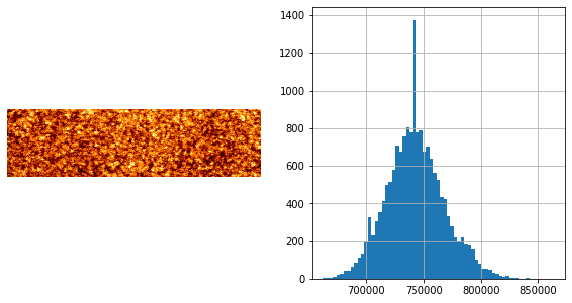

total intensity
(67, 251)
153245060.0
136601310.0
145222670.0
145168510.0


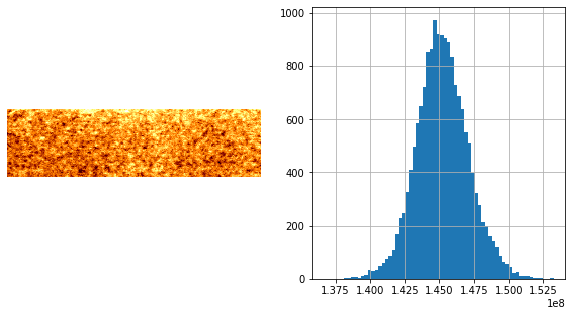

find the position of the center beam...
(67, 251, 2)
[64.84827965 63.92496103]


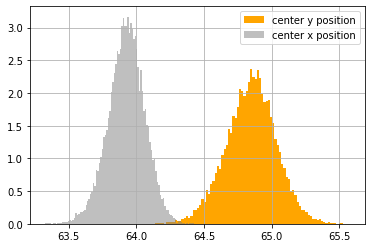

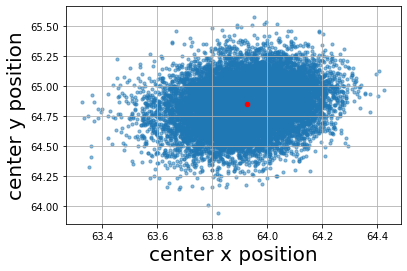

divide by median(maximum intenisties of all the center beam in vacuum)...
0.4045609
0.0
0.0041518062
0.0022670904
remove center beams...
0.0368449
0.0
0.0022964396
0.0020717646
obtain k-point variance map...
4.907295e-06
0.0
4.9370215e-07


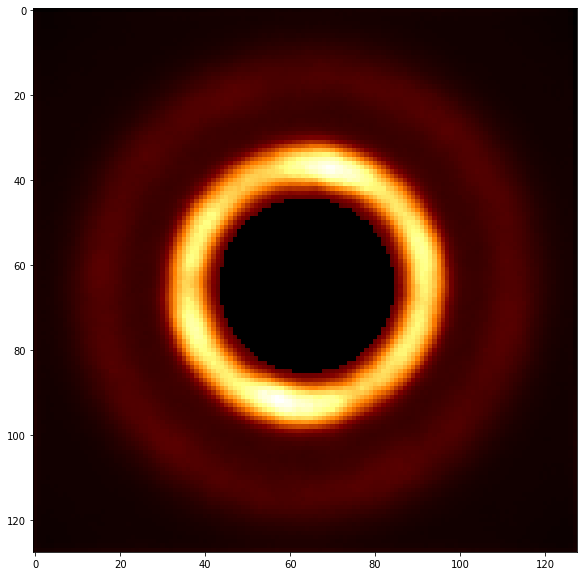

(90,)


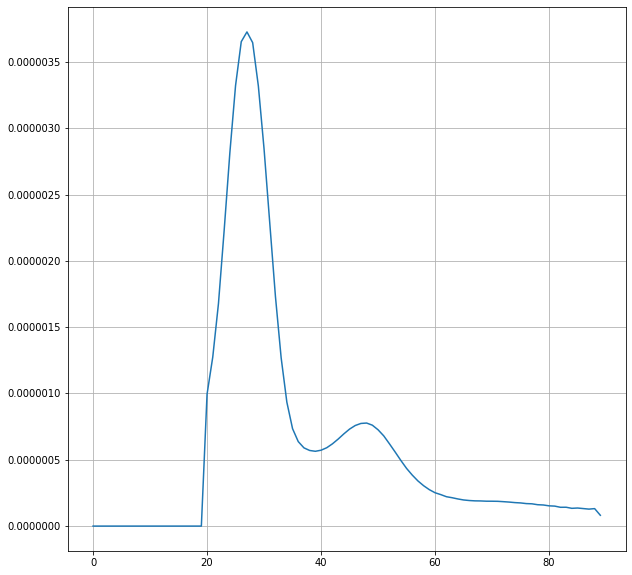

calculate radial variance and save... (vacuum center beam)
(67, 251, 90)
(90,)


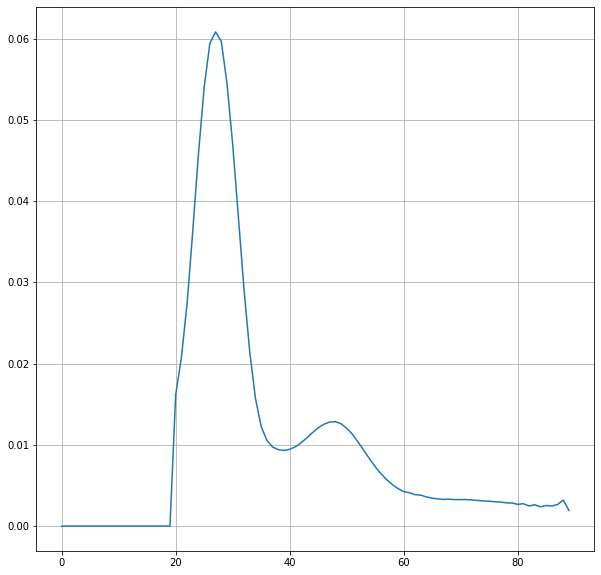

---------------------------------------------------------------
divide by median(maximum intensities of all the DPs of this data)
1.162651
0.0
0.011931689
0.006515298
remove center beams...
0.105887055
0.0
0.0065996405
0.0059539597
obtain k-point variance map...
4.052883e-05
0.0
4.0776486e-06


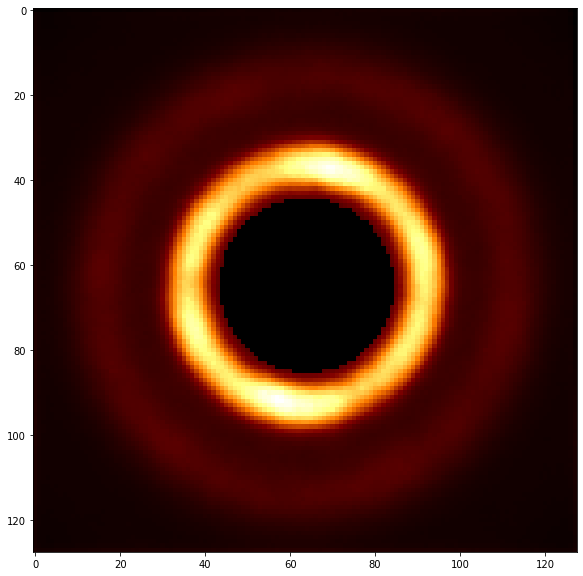

(90,)


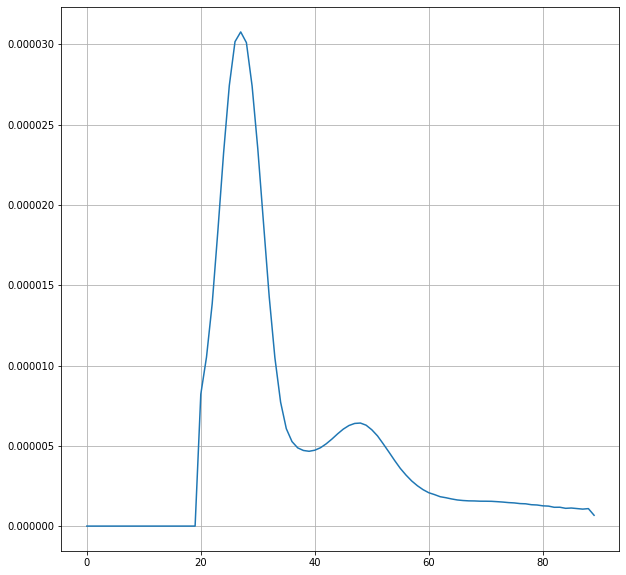

calculate radial variance and save... (median maximum intensities)
(67, 251, 90)
(90,)


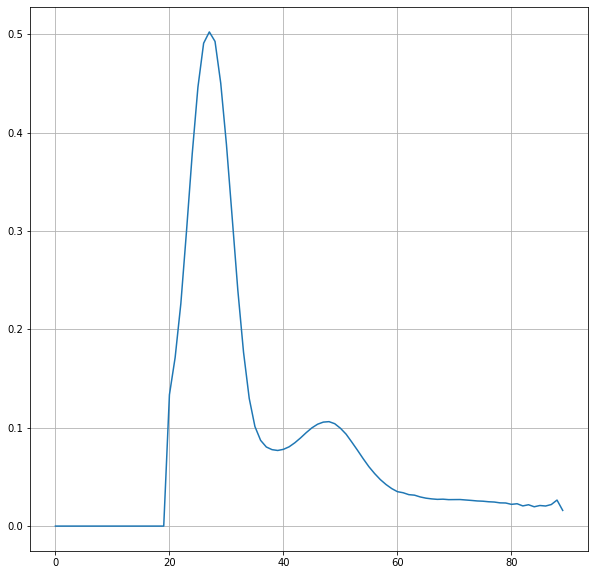

---------------------------------------------------------------
divide by the sum of all the intensities pixel by pixel
0.0057499893
0.0
6.1035156e-05
[0.99999976 0.9999998  0.9999999  0.99999994 1.         1.0000001
 1.0000002 ]
remove center beams...
0.0005448929
0.0
3.3769178e-05
3.0460502e-05
obtain k-point variance map...
1.0673245e-09
0.0
1.07064524e-10


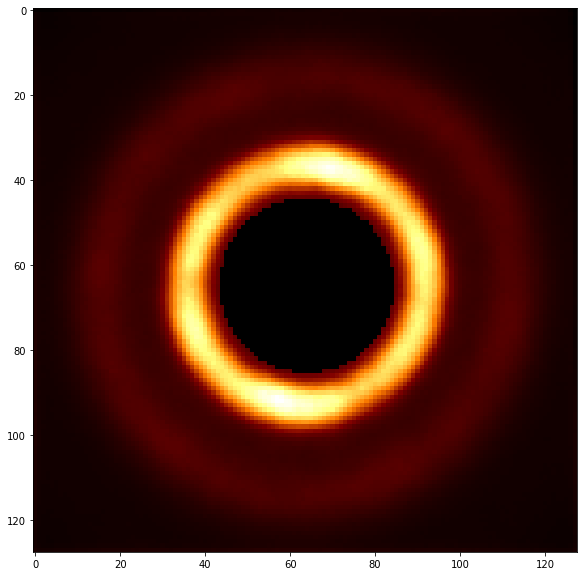

(90,)


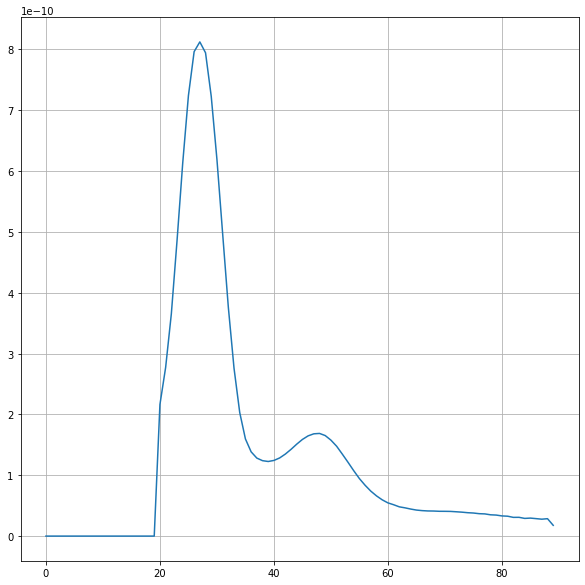

calculate radial variance and save... (probability density distribution)
(67, 251, 90)
(90,)


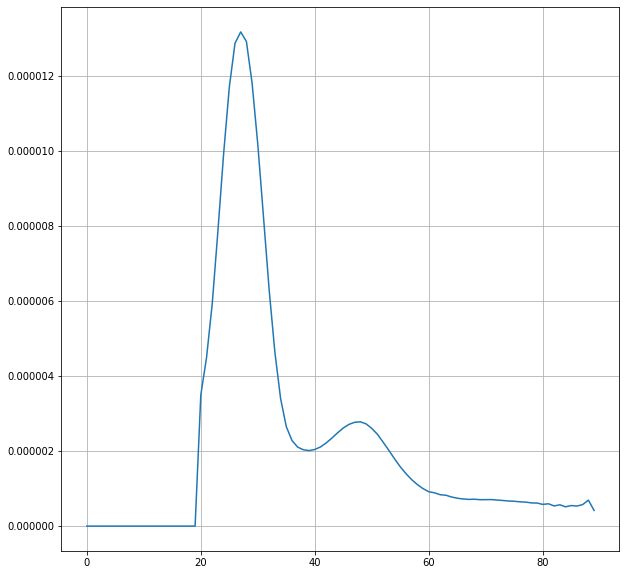

---------------------------------------------------------------
divide by 1000000 (= no normalization)
0.863695
0.0
0.008863688526782102
0.00484
remove center beams...
0.07866
0.0
0.004902650857391327
0.004423
obtain k-point variance map...
2.236510427216178e-05
0.0
2.250237999625955e-06


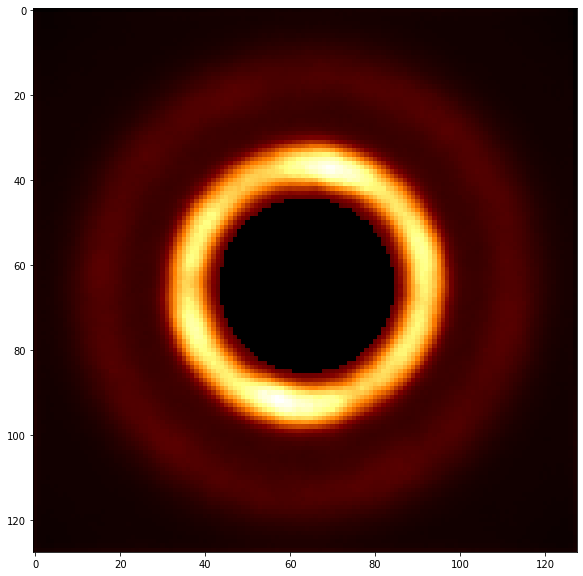

(90,)


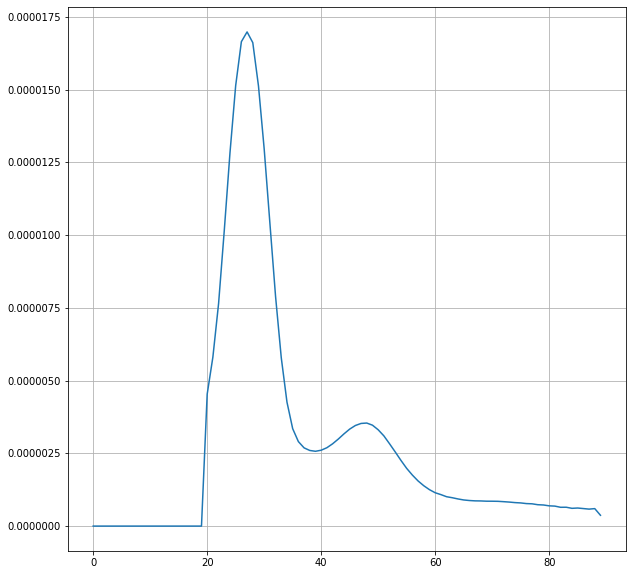

calculate radial variance and save... (no normalization)
(67, 251, 90)
(90,)


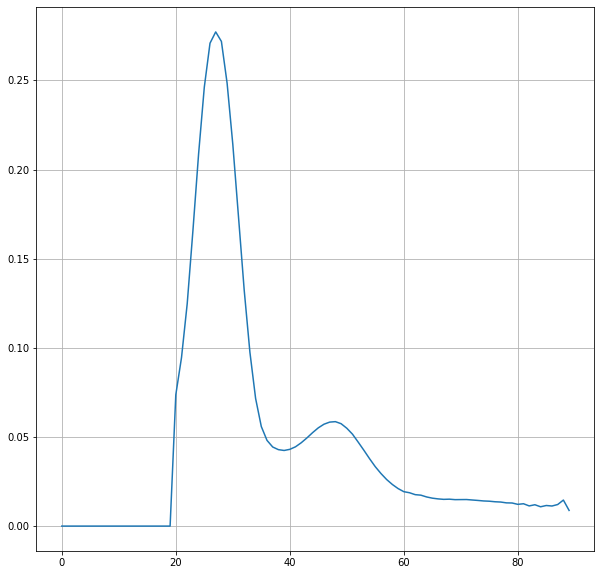

---------------------------------------------------------------
remove center beams...
78660.0
0.0
4902.665
4423.0
make the mean value = 1.0...
1.0000008
obtain k-point variance map...
0.93045473
0.0
0.09361917


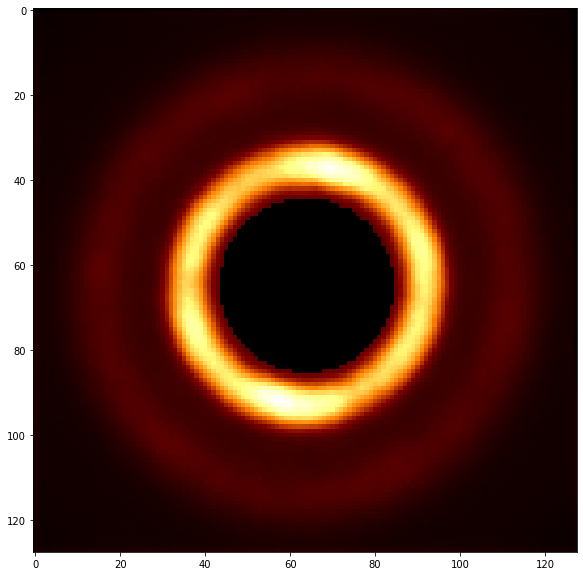

(90,)


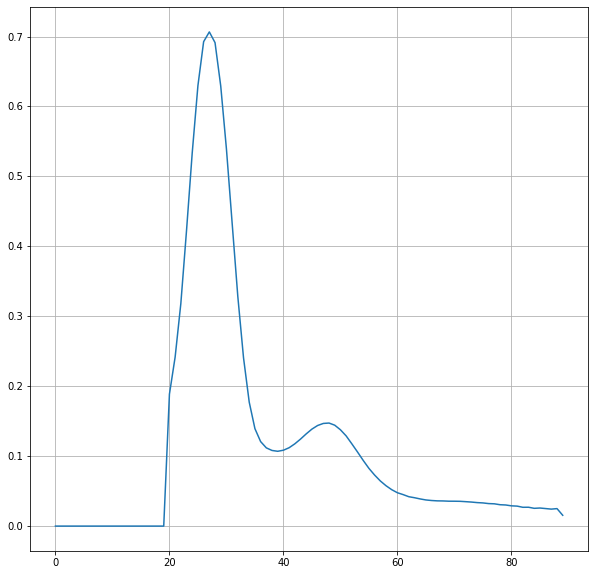

calculate radial variance and save... (the same mean)
(67, 251, 90)
(90,)


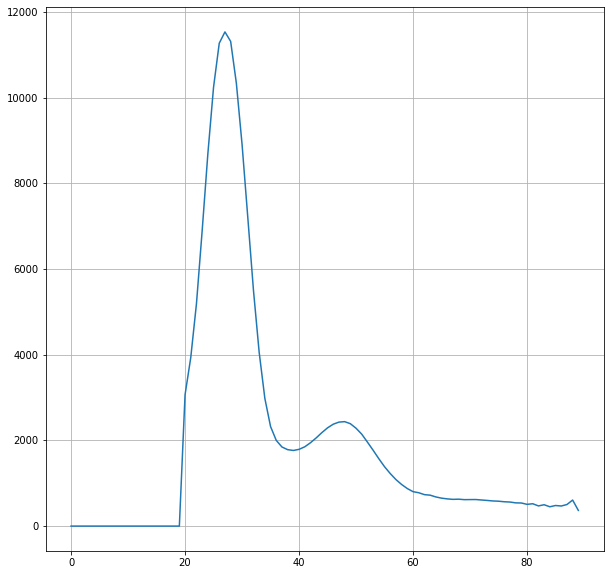

---------------------------------------------------------------
make the mean value = 1.0...
1.0000021
remove center beams...
8.874426
0.0
0.5531161
0.4990031
obtain k-point variance map...
0.2846589
0.0
0.028642237


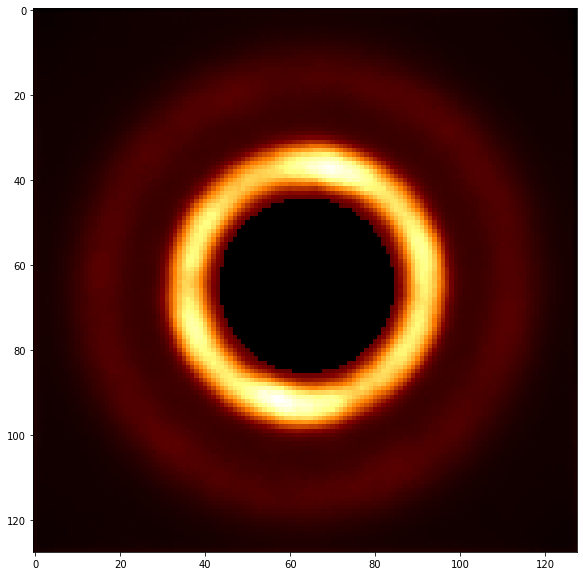

(90,)


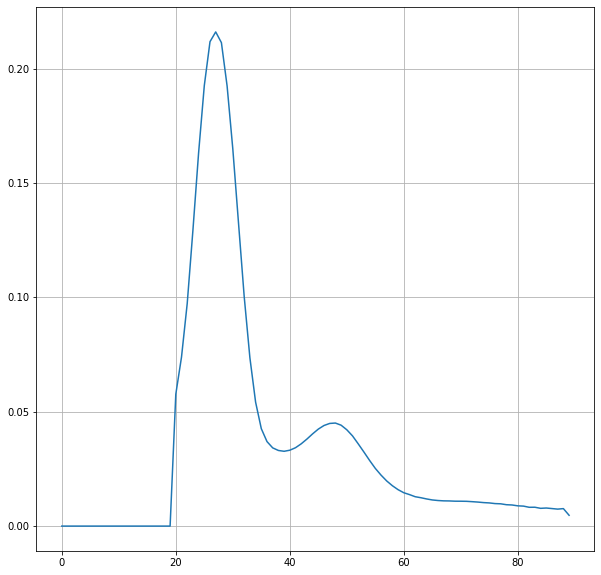

calculate radial variance and save... (the same mean)


In [ ]:
%matplotlib inline

# crop the data
stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()
print("after cropping...")
print(stack_4d_cropped.shape)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))


# maximum intensity distribution
print("maximum intensities...")
max_int = np.max(stack_4d_cropped, axis=(2, 3))
print(max_int.shape)
print(np.max(max_int))
print(np.min(max_int))
print(np.mean(max_int))
print(np.median(max_int))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(max_int, cmap="afmhot")
ax[0].axis("off")
ax[1].hist(max_int.flatten(), bins=len(max_int))
ax[1].grid()
plt.show()

# total intensity distribution
print("total intensity")
tot_int = np.sum(stack_4d_cropped, axis=(2, 3))
print(tot_int.shape)
print(np.max(tot_int))
print(np.min(tot_int))
print(np.mean(tot_int))
print(np.median(tot_int))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(tot_int, cmap="afmhot")
ax[0].axis("off")
ax[1].hist(tot_int.flatten(), bins=len(tot_int))
ax[1].grid()
plt.show()


# find center position
print("find the position of the center beam...")
center_pos = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        center_pos.append(gaussian_center(stack_4d_cropped[i, j], cbox_edge=30))
        
center_pos = np.asarray(center_pos)
center_pos = np.reshape(center_pos, (stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1))
print(center_pos.shape)
center_mean = np.mean(center_pos, axis=(0, 1))
print(center_mean)

# center distibution
plt.figure()
plt.hist(center_pos[:, :, 0].flatten(), bins=100, density=True, color="orange", label="center y position")
plt.hist(center_pos[:, :, 1].flatten(), bins=100, density=True, color="gray", alpha=0.5, label="center x position")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.scatter(center_pos[:, :, 1], center_pos[:, :, 0], s=10.0, alpha=0.5)
plt.grid()
plt.scatter(center_mean[1], center_mean[0], s=20, c="red")
plt.xlabel("center x position", fontsize=20)
plt.ylabel("center y position", fontsize=20)
plt.show()


# vacuum center beam intensity normalization
print("divide by median(maximum intenisties of all the center beam in vacuum)...")
stack_4d_cropped = stack_4d_cropped / vacuum_cb_intensity
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))

# remove center beam
print("remove center beams...")
center_radius = 20
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))

# obtain variance map dpending on k-vector
print("obtain k-point variance map...")
square_avg = np.mean(np.square(stack_4d_cropped), axis=(0,1))
avg_square = np.square(np.mean(stack_4d_cropped, axis=(0,1)))
var_map = (square_avg - avg_square)
print(np.max(var_map))
print(np.min(var_map))
print(np.median(var_map))
plt.figure(figsize=(10,10))
plt.imshow(var_map, cmap="afmhot")
plt.show()

# obtain radial average prifile for variance map above
kp_var = radial_average_with_center(var_map, center=center_mean.tolist())
print(kp_var.shape)

plt.figure(figsize=(10,10))
plt.plot(kp_var)
plt.grid()
plt.show()

# calculate variance with all angles at a certain k
print("calculate radial variance and save... (vacuum center beam)")
radial_var_stack = []
len_profile = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        radial_temp = radial_variance(stack_4d_cropped[i, j], center=center_mean.tolist())
        len_profile.append(len(radial_temp))
        radial_var_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(len_profile)):
        radial_var_stack[i] = radial_var_stack[i][:shortest]

radial_var_stack = np.asarray(radial_var_stack).reshape(stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(radial_var_stack.shape)

radial_var_sum = np.sum(radial_var_stack, axis=(0, 1))
print(radial_var_sum.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_var_sum)
plt.grid()
plt.show()

# save (radial variance, 3D)
radial_var_stack = hys.signals.Signal1D(radial_var_stack)
radial_var_stack.metadata.General.set_item("notes", center_mean.tolist())
radial_var_stack.save(raw_adr[:-4]+"_radial_var_radial_vacuum_cb.hdf5")


print("---------------------------------------------------------------")
stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()

# median maximum intensity normalization
print("divide by median(maximum intensities of all the DPs of this data)")
stack_4d_cropped = stack_4d_cropped / np.median(np.max(stack_4d_cropped, axis=(2,3)))
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))

# remove center beam
print("remove center beams...")
center_radius = 20
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))

# obtain variance map dpending on k-vector
print("obtain k-point variance map...")
square_avg = np.mean(np.square(stack_4d_cropped), axis=(0,1))
avg_square = np.square(np.mean(stack_4d_cropped, axis=(0,1)))
var_map = (square_avg - avg_square)
print(np.max(var_map))
print(np.min(var_map))
print(np.median(var_map))
plt.figure(figsize=(10,10))
plt.imshow(var_map, cmap="afmhot")
plt.show()

# obtain radial average prifile for variance map above
kp_var = radial_average_with_center(var_map, center=center_mean.tolist())
print(kp_var.shape)

plt.figure(figsize=(10,10))
plt.plot(kp_var)
plt.grid()
plt.show()

# calculate variance with all angles at a certain k
print("calculate radial variance and save... (median maximum intensities)")
radial_var_stack = []
len_profile = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        radial_temp = radial_variance(stack_4d_cropped[i, j], center=center_mean.tolist())
        len_profile.append(len(radial_temp))
        radial_var_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(len_profile)):
        radial_var_stack[i] = radial_var_stack[i][:shortest]

radial_var_stack = np.asarray(radial_var_stack).reshape(stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(radial_var_stack.shape)

radial_var_sum = np.sum(radial_var_stack, axis=(0, 1))
print(radial_var_sum.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_var_sum)
plt.grid()
plt.show()

# save (radial variance, 3D)
radial_var_stack = hys.signals.Signal1D(radial_var_stack)
radial_var_stack.metadata.General.set_item("notes", center_mean.tolist())
radial_var_stack.save(raw_adr[:-4]+"_radial_var_radial_median_max.hdf5")

print("---------------------------------------------------------------")


stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()

# total intensity normalization
print("divide by the sum of all the intensities pixel by pixel")
stack_4d_cropped = stack_4d_cropped / np.sum(stack_4d_cropped, axis=(2, 3))[:, :, np.newaxis, np.newaxis]
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.unique(np.sum(stack_4d_cropped, axis=(2, 3))))

# remove center beam
print("remove center beams...")
center_radius = 20
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))

# obtain variance map dpending on k-vector
print("obtain k-point variance map...")
square_avg = np.mean(np.square(stack_4d_cropped), axis=(0,1))
avg_square = np.square(np.mean(stack_4d_cropped, axis=(0,1)))
var_map = (square_avg - avg_square)
print(np.max(var_map))
print(np.min(var_map))
print(np.median(var_map))
plt.figure(figsize=(10,10))
plt.imshow(var_map, cmap="afmhot")
plt.show()

# obtain radial average prifile for variance map above
kp_var = radial_average_with_center(var_map, center=center_mean.tolist())
print(kp_var.shape)

plt.figure(figsize=(10,10))
plt.plot(kp_var)
plt.grid()
plt.show()

# calculate variance with all angles at a certain k
print("calculate radial variance and save... (probability density distribution)")
radial_var_stack = []
len_profile = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        radial_temp = radial_variance(stack_4d_cropped[i, j], center=center_mean.tolist())
        len_profile.append(len(radial_temp))
        radial_var_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(len_profile)):
        radial_var_stack[i] = radial_var_stack[i][:shortest]

radial_var_stack = np.asarray(radial_var_stack).reshape(stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(radial_var_stack.shape)

radial_var_sum = np.sum(radial_var_stack, axis=(0, 1))
print(radial_var_sum.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_var_sum)
plt.grid()
plt.show()

# save (radial variance, 3D)
radial_var_stack = hys.signals.Signal1D(radial_var_stack)
radial_var_stack.metadata.General.set_item("notes", center_mean.tolist())
radial_var_stack.save(raw_adr[:-4]+"_radial_var_radial_density_distribution.hdf5")

print("---------------------------------------------------------------")


stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()

# median maximum intensity normalization
print("divide by 1000000 (= no normalization)")
stack_4d_cropped = stack_4d_cropped / 1000000
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))

# remove center beam
print("remove center beams...")
center_radius = 20
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))

# obtain variance map dpending on k-vector
print("obtain k-point variance map...")
square_avg = np.mean(np.square(stack_4d_cropped), axis=(0,1))
avg_square = np.square(np.mean(stack_4d_cropped, axis=(0,1)))
var_map = (square_avg - avg_square)
print(np.max(var_map))
print(np.min(var_map))
print(np.median(var_map))
plt.figure(figsize=(10,10))
plt.imshow(var_map, cmap="afmhot")
plt.show()

# obtain radial average prifile for variance map above
kp_var = radial_average_with_center(var_map, center=center_mean.tolist())
print(kp_var.shape)

plt.figure(figsize=(10,10))
plt.plot(kp_var)
plt.grid()
plt.show()

# calculate variance with all angles at a certain k
print("calculate radial variance and save... (no normalization)")
radial_var_stack = []
len_profile = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        radial_temp = radial_variance(stack_4d_cropped[i, j], center=center_mean.tolist())
        len_profile.append(len(radial_temp))
        radial_var_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(len_profile)):
        radial_var_stack[i] = radial_var_stack[i][:shortest]

radial_var_stack = np.asarray(radial_var_stack).reshape(stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(radial_var_stack.shape)

radial_var_sum = np.sum(radial_var_stack, axis=(0, 1))
print(radial_var_sum.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_var_sum)
plt.grid()
plt.show()

# save (radial variance, 3D)
radial_var_stack = hys.signals.Signal1D(radial_var_stack)
radial_var_stack.metadata.General.set_item("notes", center_mean.tolist())
radial_var_stack.save(raw_adr[:-4]+"_radial_var_radial_no_normalization.hdf5")

print("---------------------------------------------------------------")

stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()


# remove center beam
print("remove center beams...")
center_radius = 20
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))

# make the mean value a certain value for all the data
print("make the mean value = 1.0...")
cor_term = 1.0 / np.mean(stack_4d_cropped)
stack_4d_cropped *= cor_term
print(np.mean(stack_4d_cropped))

# obtain variance map dpending on k-vector
print("obtain k-point variance map...")
square_avg = np.mean(np.square(stack_4d_cropped), axis=(0,1))
avg_square = np.square(np.mean(stack_4d_cropped, axis=(0,1)))
var_map = (square_avg - avg_square)
print(np.max(var_map))
print(np.min(var_map))
print(np.median(var_map))
plt.figure(figsize=(10,10))
plt.imshow(var_map, cmap="afmhot")
plt.show()

# obtain radial average prifile for variance map above
kp_var = radial_average_with_center(var_map, center=center_mean.tolist())
print(kp_var.shape)

plt.figure(figsize=(10,10))
plt.plot(kp_var)
plt.grid()
plt.show()

# calculate variance with all angles at a certain k
print("calculate radial variance and save... (the same mean)")
radial_var_stack = []
len_profile = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        radial_temp = radial_variance(stack_4d_cropped[i, j], center=center_mean.tolist())
        len_profile.append(len(radial_temp))
        radial_var_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(len_profile)):
        radial_var_stack[i] = radial_var_stack[i][:shortest]

radial_var_stack = np.asarray(radial_var_stack).reshape(stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(radial_var_stack.shape)

radial_var_sum = np.sum(radial_var_stack, axis=(0, 1))
print(radial_var_sum.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_var_sum)
plt.grid()
plt.show()

# save (radial variance, 3D)
radial_var_stack = hys.signals.Signal1D(radial_var_stack)
radial_var_stack.metadata.General.set_item("notes", center_mean.tolist())
radial_var_stack.save(raw_adr[:-4]+"_radial_var_radial_same_mean.hdf5")

print("---------------------------------------------------------------")

stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()


# make the mean value a certain value for all the data
print("make the mean value = 1.0...")
cor_term = 1.0 / np.mean(stack_4d_cropped)
stack_4d_cropped *= cor_term
print(np.mean(stack_4d_cropped))

# remove center beam
print("remove center beams...")
center_radius = 20
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))

# obtain variance map dpending on k-vector
print("obtain k-point variance map...")
square_avg = np.mean(np.square(stack_4d_cropped), axis=(0,1))
avg_square = np.square(np.mean(stack_4d_cropped, axis=(0,1)))
var_map = (square_avg - avg_square)
print(np.max(var_map))
print(np.min(var_map))
print(np.median(var_map))
plt.figure(figsize=(10,10))
plt.imshow(var_map, cmap="afmhot")
plt.show()

# obtain radial average prifile for variance map above
kp_var = radial_average_with_center(var_map, center=center_mean.tolist())
print(kp_var.shape)

plt.figure(figsize=(10,10))
plt.plot(kp_var)
plt.grid()
plt.show()

# calculate variance with all angles at a certain k
print("calculate radial variance and save... (the same mean)")
radial_var_stack = []
len_profile = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        radial_temp = radial_variance(stack_4d_cropped[i, j], center=center_mean.tolist())
        len_profile.append(len(radial_temp))
        radial_var_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(len_profile)):
        radial_var_stack[i] = radial_var_stack[i][:shortest]

radial_var_stack = np.asarray(radial_var_stack).reshape(stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(radial_var_stack.shape)

radial_var_sum = np.sum(radial_var_stack, axis=(0, 1))
print(radial_var_sum.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_var_sum)
plt.grid()
plt.show()

# save (radial variance, 3D)
radial_var_stack = hys.signals.Signal1D(radial_var_stack)
radial_var_stack.metadata.General.set_item("notes", center_mean.tolist())
radial_var_stack.save(raw_adr[:-4]+"_radial_var_radial_same_mean_including_cb.hdf5")

In [ ]:
# maximum intensity normalization
stack_4d_cropped = stack_4d_cropped / np.max(stack_4d_cropped, axis=(2,3))
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))

In [ ]:
# median maximum intensity normalization
stack_4d_cropped = stack_4d_cropped / np.median(np.max(stack_4d_cropped, axis=(2,3)))
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))

In [ ]:
# total intensity normalization
stack_4d_cropped = stack_4d_cropped / np.sum(stack_4d_cropped, axis=(2, 3))[:, :, np.newaxis, np.newaxis]
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.unique(np.sum(stack_4d_cropped, axis=(2, 3))))

In [ ]:
# calculate variance with all angles at a certain k
radial_var_stack = []
len_profile = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        radial_temp = radial_variance(stack_4d_cropped[i, j], center=center_mean.tolist())
        len_profile.append(len(radial_temp))
        radial_var_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(len_profile)):
        radial_var_stack[i] = radial_var_stack[i][:shortest]

radial_var_stack = np.asarray(radial_var_stack).reshape(stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(radial_var_stack.shape)

radial_var_sum = np.sum(radial_var_stack, axis=(0, 1))
print(radial_var_sum.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_var_sum)
plt.grid()
plt.show()

In [ ]:
# save (radial variance, 3D)
radial_var_stack = hys.signals.Signal1D(radial_var_stack)
radial_var_stack.metadata.General.set_item("notes", center_mean.tolist())
radial_var_stack.save(raw_adr[:-4]+"_radial_var_radial.hdf5")

In [ ]:
# calculate variance with a certain angle range
radial_var_stack_angle = []
len_profile_angle = []
ang_range = [90, 120]
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        radial_temp = radial_variance_with_angle(stack_4d_cropped[i, j], angle_range=ang_range, center=center_mean.tolist())
        len_profile_angle.append(len(radial_temp))
        radial_var_stack_angle.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(len_profile)):
        radial_var_stack_angle = radial_var_stack_angle[i][:shortest]
    
radial_var_stack_angle = np.asarray(radial_var_stack_angle).reshape(stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(radial_var_stack_angle.shape)

radial_var_sum_angle = np.sum(radial_var_stack_angle, axis=(0, 1))
print(radial_var_sum_angle.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_var_sum_angle)
plt.grid()
plt.show()

In [ ]:
#if len(radial_var_sum) != len(radial_var_sum_angle):
#    temp = np.zeros(radial_var_sum.shape)
#    temp[(center_radius):(center_radius+len(radial_var_sum_angle))] = radial_var_sum_angle
#    radial_var_sum_angle = temp

plt.figure(figsize=(10, 10))
#plt.plot(radial_avg_sum/np.max(radial_avg_sum), c="orange", label="radial average")
plt.plot(kp_var/np.max(kp_var), c="blue", label="k-point variance")
plt.plot(radial_var_sum/np.max(radial_var_sum), c="red", label="radial variance")
#plt.plot(radial_var_sum_angle/np.max(radial_var_sum_angle), c="black", label="radial variance with angle range [%d, %d]"%(ang_range[0], ang_range[1]))
plt.legend(fontsize="xx-large")
plt.grid()
plt.show()

### nano crystal visualization

In [ ]:
def radial_indices(shape, center, radial_range):
    y, x = np.indices(shape)
    r = np.hypot(y - center[0], x - center[1])
    ri = np.ones(r.shape)
    
    if len(np.unique(radial_range)) > 1:
        ri[np.where(r <= radial_range[0])] = 0
        ri[np.where(r > radial_range[1])] = 0
        
    else:
        r = np.round(r)
        ri[np.where(r != round(radial_range[0]))] = 0
    
    return ri

In [ ]:
%matplotlib qt
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
radii = np.arange(len(kp_var))
def k_map(r_range):
    r1 = r_range[0]
    r2 = r_range[1]
    print(r_range)
    ax[0].cla()
    ax[1].cla()
    ax[0].plot(radii, kp_var, "k-", c="black")
    ax[0].fill_between([r1, r2], np.max(kp_var), alpha=0.5, color="red")
    ax[0].grid()
    ri = radial_indices(f_shape[2:], center=center_mean.tolist(), radial_range=r_range)
    img_temp = np.sum(np.multiply(stack_4d_cropped, ri), axis=(2,3))
    ax[1].imshow(img_temp, cmap="afmhot")
    ax[1].axis("off")
    fig.canvas.draw()
    fig.tight_layout()

range_widget = widgets.FloatRangeSlider(value=[27, 28], min=radii[0], max=radii[-1], step=0.1)
interact(k_map, r_range=range_widget)
fig.show()

In [ ]:
%matplotlib qt
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
radii = np.arange(len(kp_var))
def k_map(r_range, var_range):
    r1 = r_range[0]
    r2 = r_range[1]
    print(r_range)
    v1 = var_range[0]
    v2 = var_range[1]
    ax[0].cla()
    ax[1].cla()
    ax[2].cla()
    ax[0].plot(radii, kp_var, "k-", c="black")
    ax[0].fill_between([r1, r2], np.max(kp_var), alpha=0.5, color="red")
    ax[0].grid()
    masked = radial_var_stack.data[:, :, r1:(r2+1)]
    binsize = masked.shape[0]*masked.shape[1]
    ax[1].hist(masked.flatten(), bins=binsize, color="darkgray")
    ax[1].fill_between([v1, v2], ax[1].get_ylim()[1], alpha=0.5, color="red")
    #x_range = np.linspace(ax[1].get_xlim()[0], ax[1].get_xlim()[1], masked.shape[0]*masked.shape[1])
    #ax[1].plot(x_range, stats.skewnorm.pdf(x_range, *stats.skewnorm.fit(masked.flatten())), "k-")
    ax[1].grid()
    ri = np.ones_like(masked)
    ri[np.where(masked < v1)] = 0
    ri[np.where(masked > v2)] = 0
    ax[2].imshow(np.sum(ri, axis=2), cmap="afmhot")
    ax[2].axis("off")
    fig.canvas.draw()
    fig.tight_layout()

range_widget = widgets.IntRangeSlider(value=[27, 30], min=radii[0], max=radii[-1], step=1)
range_widget_2 = widgets.FloatRangeSlider(value=[np.percentile(radial_var_stack, 25), np.percentile(radial_var_stack, 75)], min=np.min(radial_var_stack.data), max=np.max(radial_var_stack.data), step=0.01)
interact(k_map, r_range=range_widget, var_range=range_widget_2)
fig.show()

### anlgular correlation part

In [ ]:
def round_step(arr, step_size=1):
    
    divide = np.around(arr / step_size)
    rounded = divide * step_size
    
    return rounded

In [ ]:
def point_circle(image, radius, center=None):
    
    y, x = np.indices(image.shape)
    y = y.astype("float64")
    x = x.astype("float64")
    
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
    
    y -= center[0]
    x -= center[1]
    
    angle_arr = np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            angle_arr[i, j] = np.angle(complex(x[i, j], y[i, j]), deg=True)
            
    angle_arr = angle_arr + 180
    #print(angle_arr)
    r = np.hypot(y, x)
    r = np.around(r)
    ri = np.where(r == radius)
    angle_sel = angle_arr[ri]
    value_sel = image[ri]

    return angle_sel, value_sel

In [ ]:
# angle unit [degree]
def angular_correlation(angles, values, angle_step):
    angle_diff = []
    corr_values = []
    angle_diff_candidates = np.arange(0, 361, angle_step)
    corr_val_total = np.zeros(angle_diff_candidates.shape)
    num_angle_diff = np.zeros(angle_diff_candidates.shape)
    
    for i in range(len(angles)):
        temp_diff = np.abs(angles - angles[i])
        temp_diff = round_step(temp_diff, step_size=angle_step)
        corr_temp = values * values[i] - np.square(np.mean(values))

        angle_diff.append(temp_diff)
        corr_values.append(corr_temp)
        
    angle_diff = np.asarray(angle_diff)
    corr_values = np.asarray(corr_values)
    
    for i in range(len(angle_diff_candidates)):
        temp_ind = np.where(angle_diff==angle_diff_candidates[i])
        corr_val_total[i] = np.sum(corr_values[temp_ind])
        num_angle_diff[i] = len(temp_ind[0])
        
    num_angle_diff[np.where(num_angle_diff==0)] = 1.0
    corr_val_total /= np.square(np.mean(values))
    corr_val_total /= num_angle_diff
            
    return corr_val_total

In [ ]:
start_time = time.process_time()
angle_step = 10
angular_corr = []
radius_range = np.arange(21, 35, 2)
angle_range = np.arange(0, 361, angle_step)
k=0
for h in range(len(radius_range)):
    temp = []
    for i in range(stack_4d_cropped.shape[0]):
        for j in range(stack_4d_cropped.shape[1]):
            angle_sel, value_sel = point_circle(stack_4d_cropped[i, j], radius_range[h], center=center_mean.tolist())
            ang_cor = angular_correlation(angle_sel, value_sel, angle_step)
            temp.append(ang_cor)
            k += 1
            if (k % 100 ==0):
                print("%.2f percent complete"%(k*100/(len(radius_range)*stack_4d_cropped.shape[0]*stack_4d_cropped.shape[1])))
                print("%d seconds have passed"%(time.process_time()-start_time))
    angular_corr.append(temp)
print("all done")

In [ ]:
angular_corr = np.asarray(angular_corr).reshape(len(radius_range), stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(angular_corr.shape)
ang_corr_sum = np.sum(angular_corr, axis=(1, 2))
print(ang_corr_sum.shape)

In [ ]:
%matplotlib inline

In [ ]:
plt.figure(figsize=(9, 8))
plt.imshow(ang_corr_sum.T, cmap="afmhot", extent=[radius_range[0], radius_range[-1], angle_range[-1]/10, angle_range[0]/10])
plt.tight_layout()
plt.show()

In [ ]:
ang_corr_fft= np.abs(np.fft.fft(angular_corr))
print(ang_corr_fft.shape)
ang_corr_fft_sum = np.sum(ang_corr_fft, axis=(1, 2))
print(ang_corr_fft_sum.shape)

In [ ]:
plt.figure(figsize=(6, 8))
plt.imshow(ang_corr_fft_sum.T[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], cmap="afmhot")
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(stack_4d_cropped[np.nonzero(stack_4d_cropped)].flatten(), bins=5000)
#plt.xlim([0, 40])
plt.grid()
plt.show()

In [ ]:
def indices_at_r(shape, center, ir=10):
    y, x = np.indices(shape)
    r = np.hypot(y - center[0], x - center[1])
    r = np.around(r)
    
    ri = np.where(r == ir)
    
    return ri

In [ ]:
# just for some figures
ri_1 = indices_at_r(f_shape[2:], center=center_mean.tolist(), ir=27)
ri_2 = indices_at_r(f_shape[2:], center=center_mean.tolist(), ir=60)
dif = np.zeros((f_shape[2], f_shape[3]))
dif[ri_1] = 1
dif[ri_2] = 2

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(stack_4d_cropped[0, 0], cmap="gray")
ax[0].axis("off")
ax[1].imshow(stack_4d_cropped[0, 0], cmap="gray")
ax[1].imshow(dif, cmap="afmhot", alpha=0.3)
ax[1].axis("off")
fig.tight_layout()
plt.show()

### intensity ditribution analysis part

In [ ]:
dist_stack = []
dist_stack_skew_fit_params = []
dist_stack_lognorm_fit_params = []
dist_stack_gamma_fit_params = []
dist_stack_weibull_fit_params = []
ri = indices_at_r(f_shape[2:], center=center_mean.tolist(), ir=27)
for i in range(len(ri[0])):
    temp_flat = stack_4d_cropped[:, :, ri[0][i], ri[1][i]].flatten()
    dist_stack.append(temp_flat)
    dist_stack_skew_fit_params.append(stats.skewnorm.fit(temp_flat))
    dist_stack_lognorm_fit_params.append(stats.lognorm.fit(temp_flat))
    dist_stack_gamma_fit_params.append(stats.gamma.fit(temp_flat))
    dist_stack_weibull_fit_params.append(stats.weibull_min.fit(temp_flat))

dist_stack_skew_fit_params = np.asarray(dist_stack_skew_fit_params)
print(dist_stack_skew_fit_params.shape)
dist_stack_lognorm_fit_params = np.asarray(dist_stack_lognorm_fit_params)
print(dist_stack_lognorm_fit_params.shape)
dist_stack_gamma_fit_params = np.asarray(dist_stack_gamma_fit_params)
print(dist_stack_gamma_fit_params.shape)
dist_stack_weibull_fit_params = np.asarray(dist_stack_weibull_fit_params)
print(dist_stack_weibull_fit_params.shape)

dist_stack = np.asarray(dist_stack)
print(dist_stack.shape)
print(np.max(dist_stack))
print(np.min(dist_stack))
print(np.mean(dist_stack))

In [ ]:
dist_stack_2 = []
dist_stack_skew_fit_params_2 = []
dist_stack_lognorm_fit_params_2 = []
dist_stack_gamma_fit_params_2 = []
dist_stack_weibull_fit_params_2 = []
ri = indices_at_r(f_shape[2:], center=center_mean.tolist(), ir=60)
for i in range(len(ri[0])):
    temp_flat = stack_4d_cropped[:, :, ri[0][i], ri[1][i]].flatten()
    dist_stack_2.append(temp_flat)
    dist_stack_skew_fit_params_2.append(stats.skewnorm.fit(temp_flat))
    dist_stack_lognorm_fit_params_2.append(stats.lognorm.fit(temp_flat))
    dist_stack_gamma_fit_params_2.append(stats.gamma.fit(temp_flat))
    dist_stack_weibull_fit_params_2.append(stats.weibull_min.fit(temp_flat))

dist_stack_skew_fit_params_2 = np.asarray(dist_stack_skew_fit_params_2)
print(dist_stack_skew_fit_params_2.shape)
dist_stack_lognorm_fit_params_2 = np.asarray(dist_stack_lognorm_fit_params_2)
print(dist_stack_lognorm_fit_params_2.shape)
dist_stack_gamma_fit_params_2 = np.asarray(dist_stack_gamma_fit_params_2)
print(dist_stack_gamma_fit_params_2.shape)
dist_stack_weibull_fit_params_2 = np.asarray(dist_stack_weibull_fit_params_2)
print(dist_stack_weibull_fit_params_2.shape)

dist_stack_2 = np.asarray(dist_stack_2)
print(dist_stack_2.shape)
print(np.max(dist_stack_2))
print(np.min(dist_stack_2))
print(np.mean(dist_stack_2))

In [ ]:
%matplotlib qt
bin_size = 500
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
def intensity_distribution(img_point):
    ax.cla()
    ax.hist(dist_stack[img_point], bins=bin_size, density=True, color="orange")
    ax.hist(dist_stack_2[img_point], bins=bin_size, density=True, color="gray", alpha=0.5)
    xmin, xmax = plt.xlim()
    x_range = np.linspace(xmin, xmax, bin_size)
    ax.plot(x_range, stats.skewnorm.pdf(x_range, *dist_stack_skew_fit_params[img_point]), 'k-', label="skew normal")
    ax.plot(x_range, stats.lognorm.pdf(x_range, *dist_stack_lognorm_fit_params[img_point]), 'r-', label="log normal")
    ax.plot(x_range, stats.gamma.pdf(x_range, *dist_stack_gamma_fit_params[img_point]), 'g-', label="gamma")
    ax.plot(x_range, stats.weibull_min.pdf(x_range, *dist_stack_weibull_fit_params[img_point]), 'b-', label="Weibull")
    ax.plot(x_range, stats.skewnorm.pdf(x_range, *dist_stack_skew_fit_params_2[img_point]), 'k-')
    ax.plot(x_range, stats.lognorm.pdf(x_range, *dist_stack_lognorm_fit_params_2[img_point]), 'r-')
    ax.plot(x_range, stats.gamma.pdf(x_range, *dist_stack_gamma_fit_params_2[img_point]), 'g-')
    ax.plot(x_range, stats.weibull_min.pdf(x_range, *dist_stack_weibull_fit_params_2[img_point]), 'b-')
    ax.set_ylabel("number of pixels", fontsize=25)
    ax.set_xlabel("diffraction intensity", fontsize=25)
    ax.grid()
    ax.axis("auto")
    ax.legend(fontsize='xx-large')
    fig.canvas.draw()
    fig.tight_layout()

point_widget = widgets.IntSlider(value=10, min=0, max=dist_stack.shape[0], step=1)
interact(intensity_distribution, img_point=point_widget)
fig.show()

In [ ]:
stack_kp_skew_params = []
stack_kp_lognorm_params = []
stack_kp_gamma_params = []
stack_kp_weibull_params = []
for i in range(f_shape[2]):
    for j in range(f_shape[3]):
        temp_flat = stack_4d_cropped[:, :, i, j].flatten()
        stack_kp_skew_params.append(stats.skewnorm.fit(temp_flat))
        stack_kp_lognorm_params.append(stats.lognorm.fit(temp_flat))
        stack_kp_gamma_params.append(stats.gamma.fit(temp_flat))
        stack_kp_weibull_params.append(stats.weibull_min.fit(temp_flat))
        
stack_kp_skew_params = np.asarray(stack_kp_skew_params).reshape(f_shape[2], f_shape[3], -1)
print(stack_kp_skew_params.shape)
stack_kp_lognorm_params = np.asarray(stack_kp_lognorm_params).reshape(f_shape[2], f_shape[3], -1)
print(stack_kp_lognorm_params.shape)
stack_kp_gamma_params = np.asarray(stack_kp_gamma_params).reshape(f_shape[2], f_shape[3], -1)
print(stack_kp_gamma_params.shape)
stack_kp_weibull_params = np.asarray(stack_kp_weibull_params).reshape(f_shape[2], f_shape[3], -1)
print(stack_kp_weibull_params.shape)

In [ ]:
%matplotlib inline

In [ ]:
skew_dist_var_map = []
lognorm_dist_var_map = []
gamma_dist_var_map = []
weibull_dist_var_map = []
for i in range(f_shape[2]):
    for j in range(f_shape[3]):
        skew_dist_var_map.append(stats.skewnorm.var(*stack_kp_skew_params[i, j]))
        lognorm_dist_var_map.append(stats.lognorm.var(*stack_kp_lognorm_params[i, j]))
        gamma_dist_var_map.append(stats.gamma.var(*stack_kp_gamma_params[i, j]))
        weibull_dist_var_map.append(stats.weibull_min.var(*stack_kp_weibull_params[i, j]))
        
skew_dist_var_map = np.asarray(skew_dist_var_map).reshape(f_shape[2], f_shape[3])
lognorm_dist_var_map = np.asarray(lognorm_dist_var_map).reshape(f_shape[2], f_shape[3])
gamma_dist_var_map = np.asarray(gamma_dist_var_map).reshape(f_shape[2], f_shape[3])
weibull_dist_var_map = np.asarray(weibull_dist_var_map).reshape(f_shape[2], f_shape[3])

plt.figure(figsize=(10,10))
plt.imshow(skew_dist_var_map, cmap="afmhot")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(lognorm_dist_var_map, cmap="afmhot")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(gamma_dist_var_map, cmap="afmhot")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(weibull_dist_var_map, cmap="afmhot")
plt.show()

In [ ]:
temp_lognorm = lognorm_dist_var_map.copy()
temp_gamma = gamma_dist_var_map.copy()
temp_weibull = weibull_dist_var_map.copy()

temp_lognorm[np.where(temp_lognorm > np.percentile(temp_lognorm, 99.9))] = 0
temp_gamma[np.where(np.isnan(temp_gamma))] = 0
temp_gamma[np.where(temp_gamma > np.percentile(temp_gamma, 99))] = 0
temp_weibull[np.where(temp_weibull > np.percentile(temp_weibull, 88))] = 0

plt.figure(figsize=(10,10))
plt.imshow(skew_dist_var_map, cmap="afmhot")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(temp_lognorm, cmap="afmhot")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(temp_gamma, cmap="afmhot")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(temp_weibull, cmap="afmhot")
plt.show()

In [ ]:
skew_dist_var = radial_average_with_center(skew_dist_var_map, center=center_mean.tolist())
print(skew_dist_var.shape)
lognorm_dist_var = radial_average_with_center(temp_lognorm, center=center_mean.tolist())
print(lognorm_dist_var.shape)
gamma_dist_var = radial_average_with_center(temp_gamma, center=center_mean.tolist())
print(gamma_dist_var.shape)
weibull_dist_var = radial_average_with_center(temp_weibull, center=center_mean.tolist())
print(weibull_dist_var.shape)

In [ ]:
%matplotlib inline

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(skew_dist_var, c="orange", label="skew normal")
plt.plot(lognorm_dist_var, c="blue", label="log normal")
plt.plot(gamma_dist_var, c="green", label="gamma")
plt.plot(weibull_dist_var, c="red", label="weibull")
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(skew_dist_var/np.mean(skew_dist_var), c="orange", label="skew normal")
plt.plot(lognorm_dist_var/np.mean(lognorm_dist_var), c="blue", label="log normal")
plt.plot(gamma_dist_var/np.mean(gamma_dist_var), c="green", label="gamma")
plt.plot(weibull_dist_var/np.mean(weibull_dist_var), c="red", label="weibull")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# skew normal

#w = stack_kp_fit_skew_params[:, :, 2]
#delta = stack_kp_fit_skew_params[:, :, 1] / np.sqrt(1+np.square(stack_kp_fit_skew_params[:, :, 1]))
#skew_dist_var_map = np.multiply(w, 1-2*np.square(delta)/np.pi)
#print(skew_dist_var_map.shape)

skew_dist_var_map = []
for i in range(f_shape[2]):
    for j in range(f_shape[3]):
        skew_dist_var_map.append(stats.skewnorm.var(stack_kp_fit_skew_params[i, j, 0], stack_kp_fit_skew_params[i, j, 1], stack_kp_fit_skew_params[i, j, 2]))
        
skew_dist_var_map = np.asarray(skew_dist_var_map).reshape(f_shape[2], f_shape[3])

plt.figure(figsize=(10,10))
plt.imshow(skew_dist_var_map, cmap="afmhot")
plt.show()

skew_dist_var = radial_average_with_center(skew_dist_var_map, center=center_mean.tolist())
print(dist_var.shape)

In [ ]:
# log normal
#sigma = stack_kp_lognorm_params[:, :, 0]
#exp_mu = stack_kp_lognorm_params[:, :, 2]
#lognorm_dist_var_map = np.multiply((np.exp(np.square(sigma)) - 1), np.multiply(np.square(exp_mu), np.exp(np.square(sigma))))
#print(lognorm_dist_var_map.shape)

lognorm_dist_var_map = []
for i in range(f_shape[2]):
    for j in range(f_shape[3]):
        lognorm_dist_var_map.append(stats.lognorm.var(stack_kp_lognorm_params[i, j, 0], stack_kp_lognorm_params[i, j, 1], stack_kp_lognorm_params[i, j, 2]))
        
lognorm_dist_var_map = np.asarray(lognorm_dist_var_map).reshape(f_shape[2], f_shape[3])

plt.figure(figsize=(10,10))
plt.imshow(lognorm_dist_var_map, cmap="afmhot")
plt.show()

lognorm_dist_var = radial_average_with_center(lognorm_dist_var_map, center=center_mean.tolist())
print(lognorm_dist_var.shape)

In [ ]:
# gamma
gamma_dist_var_map = []
for i in range(f_shape[2]):
    for j in range(f_shape[3]):
        gamma_dist_var_map.append(stats.gamma.var(stack_kp_gamma_params[i, j, 0], stack_kp_gamma_params[i, j, 1], stack_kp_lognorm_params[i, j, 2]))
        
gamma_dist_var_map = np.asarray(gamma_dist_var_map).reshape(f_shape[2], f_shape[3])

plt.figure(figsize=(10,10))
plt.imshow(gamma_dist_var_map, cmap="afmhot")
plt.show()

gamma_dist_var = radial_average_with_center(gamma_dist_var_map, center=center_mean.tolist())
print(gamma_dist_var.shape)

In [ ]:
# weibull
weibull_dist_var_map = []
for i in range(f_shape[2]):
    for j in range(f_shape[3]):
        weibull_dist_var_map.append(stats.weibull_min.var(stack_kp_weibull_params[i, j, 0], stack_kp_weibull_params[i, j, 1], stack_kp_weibull_params[i, j, 2]))
        
weibull_dist_var_map = np.asarray(weibull_dist_var_map).reshape(f_shape[2], f_shape[3])

plt.figure(figsize=(10,10))
plt.imshow(weibull_dist_var_map, cmap="afmhot")
plt.show()

weibull_dist_var = radial_average_with_center(weibull_dist_var_map, center=center_mean.tolist())
print(weibull_dist_var.shape)

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(skew_dist_var, c="orange", label="skew normal")
plt.plot(lognorm_dist_var, c="blue", label="log normal")
plt.plot(gamma_dist_var, c="green", label="gamma")
plt.plot(weibull_dist_var, c="red", label="weibull")
#plt.plot(radial_var_sum_angle/np.max(radial_var_sum_angle), c="black", label="radial variance with angle range [%d, %d]"%(ang_range[0], ang_range[1]))
plt.legend()
plt.grid()
plt.show()

In [ ]:
stack_kp_dist = []
x_range = np.linspace(0, 100, 1000)
for i in range(f_shape[2]):
    for j in range(f_shape[3]):
        temp_dist = stats.skewnorm.pdf(x_range, stack_kp_fit_params[i, j][0], stack_kp_fit_params[i, j][1], stack_kp_fit_params[i, j][2])
        stack_kp_dist.append(temp_dist)
        
stack_kp_dist = np.asarray(stack_kp_dist).reshape(f_shape[2], f_shape[3], -1)
print(stack_kp_dist.shape)

In [ ]:
# save (fitted skew normal distribution at each k-point, 3D)
stack_kp_dist = hys.signals.Signal1D(stack_kp_dist)
stack_kp_dist.metadata.General.set_item("notes", center_mean.tolist())
stack_kp_dist.save(tkf.asksaveasfilename())

In [ ]:
# save (fitted skew normal distribution parameters at each k-point, 3D)
stack_kp_fit_params = hys.signals.Signal1D(stack_kp_fit_params)
stack_kp_fit_params.metadata.General.set_item("notes", center_mean.tolist())
stack_kp_fit_params.save(tkf.asksaveasfilename())

In [ ]:
%matplotlib inline

In [ ]:
plt.figure(figsize=(10, 10))
#plt.plot(radial_avg_sum/np.max(radial_avg_sum), c="orange", label="radial average")
plt.plot(kp_var/np.max(kp_var), c="blue", label="k-point variance")
plt.plot(dist_var/np.max(dist_var), c="green", label="k-point distribution variance")
plt.plot(radial_var_sum/np.max(radial_var_sum), c="red", label="radial variance")
#plt.plot(radial_var_sum_angle/np.max(radial_var_sum_angle), c="black", label="radial variance with angle range [%d, %d]"%(ang_range[0], ang_range[1]))
plt.legend()
plt.grid()
plt.show()